## Project Installation

This project relies on the following major dependencies:

- [**Python**](https://www.python.org/downloads/): The primary programming language used. We're using the latest Python3
- [**Jupyter Notebook**](https://jupyter.org/install): Handles the .ipynb format file execution.
- [**VSCode**](https://code.visualstudio.com/): Code editor and simple notebook environment.
- **Libraries**: 
  - `opencv-python`: For image processing and computer vision tasks.
  - `scikit-learn`: For machine learning algorithms and data preprocessing.
  - `xgboost`: An efficient implementation of gradient boosting framework.
  - `numpy`: Essential for numerical operations.
  - `matplotlib`: For plotting and visualization of data.
  - `onnxconverter-common`: Common utilities for ONNX model conversion.
  - `onnxmltools`: Tools for converting machine learning models to ONNX format.
  - `skl2onnx`: Specifically for converting scikit-learn models to ONNX format.
  - `google.colab`: Google Colaboratory ONLY - Python notebook format.

Easy Jupyter Notebook installation (with Python3 already installed):
- Open this file in [VSCode](https://code.visualstudio.com/) and use extensions (VSCode will prompt you) to configure and run the python and jupyter env.

### Install Dependencies:

#### In your command prompt with Python 3 installed, type:
`pip install -r requirements.txt`

## Data Download and Extraction

### Download the dataset and unzip it (linux example calls)
`wget https://storage.googleapis.com/fishazam-sample-dataset/spectrum_dataset.zip`

`unzip spectrum_dataset.zip -d ./content`

## Import Libraries and Setup Paths

In [7]:
# Import Path from pathlib for file path operations
from pathlib import Path
# Import Pipeline from sklearn for creating a ML pipeline
from sklearn.pipeline import Pipeline
# Import StandardScaler for feature scaling
from sklearn.preprocessing import StandardScaler
# Import XGBClassifier for the classification model
from xgboost import XGBClassifier
# Import numpy for numerical operations
import numpy as np  # Import the required Python module
# Import pyplot from matplotlib for plotting
from matplotlib import pyplot as plt
# Import sklearn metrics for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
# Import files from google.colab for file operations
#from google.colab import files

## Data Preparation
Training and Test data are folders, Labels are subfolders.


In [8]:
TRAIN_PATH = Path("./content/training")
TEST_PATH = Path("./content/testing")

LABELS = ['alaskacod', 'alaskanhalibut', 'other', 'pacificcod', 'petralesole', 'rockfish','tilapia']
FLAT_SIZE=3200


## Model Pipeline Creation

In [9]:
# Define a function to load, resize, and flatten image data, and prepare labels
def load_data(dataset_path: Path) -> (list, list, dict):
    data = []
    labels = []
    label_dict = {}
    for f in sorted(dataset_path.glob("**/*.csv")):
        if f.is_dir():
            continue
        current = np.genfromtxt(f, delimiter=',')
        data.append(current[1:].flatten())

        lbl = f.parent.name  
        #lbl = f.stem.split("_")[0] 
        # If the label is not already in the label dictionary, add it with a unique integer
        if lbl not in label_dict:
            label_dict[lbl] = len(label_dict)

        labels.append(label_dict[lbl])

    return data, labels, label_dict

## Load Train and Test Data

In [10]:
X_train, y_train, train_labels = load_data(TRAIN_PATH)
X_test, y_test, test_labels = load_data(TEST_PATH)

## Model Prediction and Evaluation

In [11]:
# Create a pipeline for data preprocessing and model training
pipe = Pipeline([
        # The first step in the pipeline: Standardize features by removing the mean and scaling to unit variance
        ("scaler", StandardScaler()),
        # The second step in the pipeline: Train a classifier using the XGBoost algorithm
        # with specified parameters (1 estimator and verbosity level 2)
        # ("pca", PCA()),  # Add optional PCA decomposition
        ("xgb", XGBClassifier(n_estimators=3, enable_categorical=True, verbosity=2))
    ])

In [12]:
pipe.fit(X_train, y_train)   # Train on labeled data

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=3, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [13]:
preds = pipe.predict(X_test)  # Predict unlabeled data

                precision    recall  f1-score   support

     alaskacod       1.00      1.00      1.00         2
alaskanhalibut       1.00      1.00      1.00         4
         other       1.00      1.00      1.00         1
    pacificcod       1.00      1.00      1.00         4
   petralesole       1.00      1.00      1.00         2
      rockfish       1.00      1.00      1.00         2
       tilapia       1.00      1.00      1.00         2

      accuracy                           1.00        17
     macro avg       1.00      1.00      1.00        17
  weighted avg       1.00      1.00      1.00        17



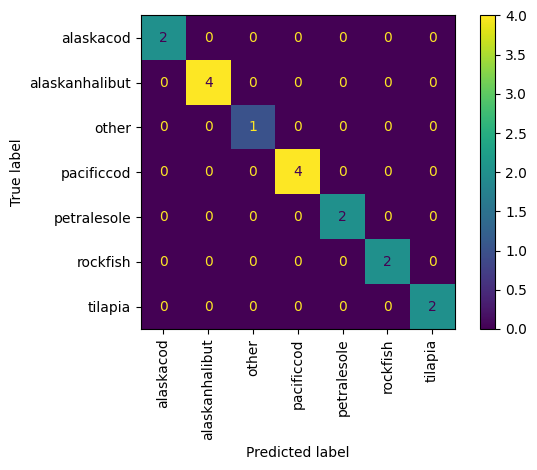

In [14]:
cm = confusion_matrix(y_test, preds)  # a specific table layout that allows visualization of the performance of an algorithm
print(classification_report(y_test, preds, target_names=test_labels))
disp = ConfusionMatrixDisplay(cm, display_labels=test_labels)
disp.plot(xticks_rotation="vertical")
plt.tight_layout()
plt.show()  # Plot predictions, a good result should have a diagonal from top left to bottom right

Model accuracy defined by number of correct guesses vs incorrect guesses.

## Convert Trained Model to ONNX for Applications.

ONNX lets us package the trained python models optimized for runtime applications (e.g. web applications)

In [15]:
from onnxconverter_common import FloatTensorType
from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost
from skl2onnx import update_registered_converter, convert_sklearn
from skl2onnx.common.shape_calculator import calculate_linear_classifier_output_shapes

In [16]:
# Define options for the converter
opts = {
    "nocl": [True, False],  # Option for 'nocl': Indicates whether to use 'no class labels' in the output
    "zipmap": [True, False, "columns"],  # Option for 'zipmap': Determines how to output class probabilities,
                                         # either as a dictionary (True), array (False), or as columns ("columns")
    "output_class_labels": [True, False]  # Option for 'output_class_labels': Indicates whether to output class labels
}

# Update or register a new converter for XGBClassifier with the ONNX converter
update_registered_converter(
    XGBClassifier,  # The scikit-learn classifier class that we want to convert to ONNX
    "XGBoostXGBClassifier",  # The name for the converter (as registered in ONNX)
    calculate_linear_classifier_output_shapes,  # Function to calculate the output shape of the converted model
    convert_xgboost,  # Function that defines how to convert the classifier to an ONNX model
    options=opts,  # Passing the options defined above to customize the conversion process
)

In [17]:
# Convert the scikit-learn pipeline to ONNX format
model_onnx = convert_sklearn(
    pipe,  # The scikit-learn model or pipeline to convert, here 'pipe' refers to a predefined pipeline
    "fishazam-xgboost-classifier",  # Name for the ONNX model
    [("input", FloatTensorType([1, FLAT_SIZE]))],  # Define the model input name and type
    # 'input' is the name of the input tensor,
    # FloatTensorType([1, FLAT_IMG_SIZE]) specifies the data type and shape of the input tensor
    target_opset={"": 12, "ai.onnx.ml": 2},  # Specify the target ONNX operator set versions
    # "" refers to the default ONNX domain, with version 12
    # "ai.onnx.ml" refers to the machine learning domain, with version 2
    options={id(pipe): {"zipmap": False, "output_class_labels": False, "nocl": True}}
    # Set conversion options for the pipeline
    # "zipmap": False - Do not convert class probabilities to a dictionary format
    # "output_class_labels": False - Do not output the class labels
    # "nocl": True - Indicate that there are no class labels in the output
)

In [18]:
with open("fishazam-xgboost-classifier-spectrum.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

#files.download("fishazam-xgboost-classifier-spectrum.onnx")  # Save the trained model compilation.

Use [https://netron.app/](https://netron.app/) to evaluate the ONNX outputs. You need to format i/o into tensors with specific buffer types which are limited to:

- bool
- float16
- float32
- float64
- int16
- int32
- int8
- string
- uint16
- uint32
- uint64
- uint8